<a href="https://colab.research.google.com/github/O-suke12/Semantic_Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from PIL import Image
import os
from google.colab import files
import torch.nn.functional as F
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
import albumentations as A

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Reference**





Dataset: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset?sort=votes

# **Dataset**

In [19]:
if os.path.exists("kaggle.json"):
  print("already exist")
else:
  uploaded = files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download -d bulentsiyah/semantic-drone-dataset
  ! unzip  semantic-drone-dataset

already exist


In [20]:
df_class = pd.read_csv("/content/class_dict_seg.csv")
df_class.head()

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87


In [21]:
import os
from sklearn.model_selection import train_test_split

dict = {"Name":[]}
df = pd.DataFrame(dict)
df = pd.DataFrame(os.listdir("/content/RGB_color_image_masks/RGB_color_image_masks"))
df_train, df_valid = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=42)

In [46]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from  torchvision import transforms
from torch.utils.data.dataloader import DataLoader

t_train = A.Compose([
    A.Resize(640, 800),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    ToTensorV2()
])

t_valid = A.Compose([
    A.Resize(704,1052),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

class Custom_dataset(Dataset):
  def __init__(self, image_dir, mask_dir, df, transform=True):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    image = np.array(Image.open(image_dir+"/"+self.df.iloc[idx,0][:-3]+"jpg"))
    mask = np.array(Image.open(mask_dir+"/"+self.df.iloc[idx,0]))
    aug = self.transform(image=image, mask=mask)
    image = aug["image"]
    mask = aug["mask"]
    return image, mask

image_dir = "/content/dataset/semantic_drone_dataset/original_images"
mask_dir = "/content/dataset/semantic_drone_dataset/label_images_semantic"

CD_train = Custom_dataset(image_dir, mask_dir, df_train, t_train)
CD_valid = Custom_dataset(image_dir, mask_dir, df_valid, t_valid)
CD_test = Custom_dataset(image_dir, mask_dir, df_test, t_valid)
train_loader = DataLoader(CD_train, batch_size=3, shuffle=True, drop_last=True)
valid_loader = DataLoader(CD_valid, batch_size=3, shuffle=True, drop_last=True)

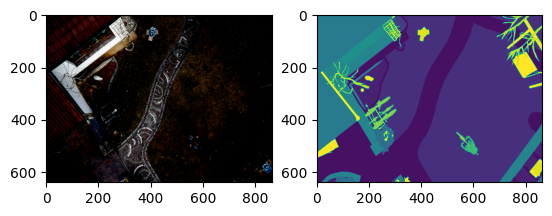

In [32]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2)
axes[0].imshow(CD_train.__getitem__(2)[0].permute(1,2,0))
axes[1].imshow(CD_train.__getitem__(2)[1])

# **Model**

In [24]:
# from torchvision.transforms.functional import resize

# class double_conv(nn.Module):
#   def __init__(self, in_features, out_features):
#     super().__init__()
#     self.conv_block = nn.Sequential(
#         nn.Conv2d(in_features, out_features, 3, padding=1),
#         nn.BatchNorm2d(out_features),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(out_features, out_features, 3, padding=1),
#         nn.BatchNorm2d(out_features),
#         nn.ReLU(inplace=True),
#     )

#   def forward(self,X):
#     return  self.conv_block(X)

# class UNET(nn.Module):
#   def __init__(self,):
#     super().__init__()
#     self.encode1 = nn.Sequential(
#         double_conv(3, 64),
#     )
#     self.encode2 = nn.Sequential(
#         nn.MaxPool2d(2,2),
#         double_conv(64, 128),
#     )
#     self.encode3 = nn.Sequential(
#         nn.MaxPool2d(2,2),
#         double_conv(128, 256),
#     )
#     self.encode4 = nn.Sequential(
#         nn.MaxPool2d(2,2),
#         double_conv(256, 512),
#     )
#     self.bottleneck = nn.Sequential(
#         nn.MaxPool2d(2,2),
#         double_conv(512, 1024),
#     )

#     self.decode1 = nn.Sequential(
#         nn.ConvTranspose2d(1024,512,2,2),
#     )

#     self.decode2 = nn.Sequential(
#         double_conv(1024, 512),
#         nn.ConvTranspose2d(512,256,2,2),
#     )

#     self.decode3 = nn.Sequential(
#         double_conv(512, 256),
#         nn.ConvTranspose2d(256,128,2,2),
#     )

#     self.decode4 = nn.Sequential(
#         double_conv(256,128),
#         nn.ConvTranspose2d(128,64,2,2),
#     )

#     self.last_conv = nn.Sequential(
#         double_conv(128,64),
#         nn.Conv2d(64,3,kernel_size=1)
#     )

#   def forward(self,X):
#     u1 = X = self.encode1(X)
#     u2 = X = self.encode2(X)
#     u3 = X = self.encode3(X)
#     u4 = X = self.encode4(X)

#     X = self.bottleneck(X)

#     X = self.decode1(X)
#     X = resize(X, u4.shape[2:])
#     X = self.decode2(torch.cat((u4,X),dim=1))
#     X = resize(X, u3.shape[2:])
#     X = self.decode3(torch.cat((u3,X),dim=1))
#     X = resize(X, u2.shape[2:])
#     X = self.decode4(torch.cat((u2,X),dim=1))
#     X = resize(X, u1.shape[2:])
#     return self.last_conv(torch.cat((u1,X),dim=1))


# model = UNET()
# model = model.to(device)

In [26]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=len(df_class), init_features=64, pretrained=False)
# model.to(device)

In [27]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model.to(device)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

# **Utils**

In [28]:
def pixel_accuracy(pred, truth):
    with torch.no_grad():
        pred = pred.type(torch.float)
        truth = truth.type(torch.float)
        correct = torch.eq(pred, truth).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

# **Train and Evaluation**

In [39]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scaler = torch.cuda.amp.GradScaler()

train_losses =[]
valid_losses = []

for epoch in range(epochs):
    train_loss = 0

    for batch, mask in tqdm(train_loader):
        model.train()
        batch = batch.to(device)
        mask = mask.to(device)
        mask = mask.type(torch.long)
        with torch.cuda.amp.autocast():
            y_pred = model(batch)
            loss = loss_fn(y_pred, mask)
        train_loss += loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.inference_mode():
        for batch, mask in tqdm(valid_loader):
            batch = batch.to(device)
            mask = mask.to(device)
            mask = mask.type(torch.long)
            y_pred = model(batch)
            valid_loss += loss_fn(y_pred, mask)

    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(valid_loss/len(valid_loader))
    print(f"\nEpoch: {epoch+1} | Train_loss: {train_loss/len(train_loader):.5f} | Validation_loss: {valid_loss/len(valid_loader):.5f}\n")

 91%|█████████ | 98/108 [03:53<00:23,  2.34s/it]

In [1]:
plt.figure()

fig, axes = plt.subplots(1,3)
softmax = nn.Softmax(dim=1)
sample_X = CD_test.__getitem__(2)[0].to(device)
sample_y = CD_test.__getitem__(2)[1]
sample_pred = model(sample_X.unsqueeze(0)).to(device)
sample_pred = torch.tensor(sample_pred.cpu().squeeze(0))
sample_pred = torch.argmax(softmax(sample_pred),axis=0)
axes[0].imshow(sample_X.cpu().permute(1,2,0))
axes[1].imshow(sample_y)
axes[2].imshow(sample_pred)
print(pixel_accuracy(sample_pred.unsqueeze(0), sample_y.unsqueeze(0)))

NameError: ignored